In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/TechBytes/ml-100k')

In [11]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = f'{os.getcwd()}'+'/'
print(data_path)

/content/drive/MyDrive/Colab Notebooks/TechBytes/ml-100k/


In [42]:
id_val = 1
num_users = 943
num_videos = 1682
train_dataframe = pd.read_csv(f'{data_path}u{id_val}.base',sep='\t',header=None)
train_dataframe.columns = ['user_id','video_id','watch_time','ts']
train_dataframe['user_id'] = train_dataframe['user_id'] - 1
train_dataframe['video_id'] = train_dataframe['video_id'] - 1
valid_df = pd.read_csv(f'{data_path}u{id_val}.test',sep='\t',header=None)
valid_df.columns = ['user_id','video_id','watch_time','ts']
valid_df['user_id'] = valid_df['user_id'] -1
valid_df['video_id'] = valid_df['video_id'] -1
train_dataframe.shape, valid_df.shape

((80000, 4), (20000, 4))

In [43]:
train_dataframe.head(100)

,user_id,video_id,watch_time,ts
0,0,0,5,874965758
1,0,1,3,876893171
2,0,2,4,878542960
3,0,3,3,876893119
4,0,4,3,889751712
...,...,...,...,...
95,0,178,3,875072370
96,0,180,5,874965739
97,0,181,4,875072520
98,0,186,4,874965678


In [45]:
train_usrs = train_dataframe.user_id.unique()
vald_usrs = valid_df.user_id.unique()
len(train_usrs),len(vald_usrs)
train_videos = train_dataframe.video_id.unique()
vald_videos = valid_df.video_id.unique()
len(train_videos),len(vald_videos)

(1650, 1410)

In [46]:
class CollabDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, watch_time_col=2):
        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col], dtype=torch.long, device = device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col], dtype=torch.long, device = device)
        self.target_tensor = torch.tensor(self.df.iloc[:,watch_time_col], dtype=torch.float32, device = device)

    def __getitem__(self, index):
        return(self.user_tensor[index], self.item_tensor[index], self.target_tensor[index])

    def __len__(self):
        return(self.user_tensor.shape[0])
batch_size = 2000
train_dataset = CollabDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataset = CollabDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [47]:
class ConcatNet(nn.Module):
    def __init__(self, config):
        super(ConcatNet, self).__init__()
        #hyperparameters
        self.config = config
        self.num_users = config['num_users']
        self.num_videos = config['num_videos']
        self.emb_size = config['emb_size']
        self.emb_droupout = config['emb_droupout']
        self.fc_layer_sizes = config['fc_layer_sizes']
        self.dropout = config['dropout']
        self.out_range = config['out_range']

        #embeddings
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_videos, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))

        #fully-connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_layer_sizes[:-1], self.fc_layer_sizes[1:], self.dropout):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_layer_sizes[-1], out_features=1)

    def forward(self, user_idx, video_idx):
        user_emb = self.emb_user(user_idx)
        item_emb = self.emb_item(video_idx)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc_layers(x)
        x = torch.sigmoid(self.head(x))
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        return(x)


config = {
    'num_users':943,
    'num_videos':1682,
    'emb_size':50,
    'emb_droupout': 0.05,
    'fc_layer_sizes': [100, 512, 256],
    'dropout': [0.7,0.35],
    'out_range': [0.8,5.2]}
model = ConcatNet(config)
model

ConcatNet(
  (emb_user): Sequential(
    (0): Embedding(943, 50)
    (1): Dropout(p=0.05, inplace=False)
  )
  (emb_item): Sequential(
    (0): Embedding(1682, 50)
    (1): Dropout(p=0.05, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35, inplace=False)
  )
  (head): Linear(in_features=256, out_features=1, bias=True)
)

In [48]:
batch_size = 2000
learning_rate = 1e-2
weight_decay = 5e-1
num_epoch = 50
reduce_learning_rate = 1
early_stoping = 5


learning_rates = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

train_dataset = CollabDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataset = CollabDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

model = ConcatNet(config)
criterion = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), betas=(0.9,0.999), weight_decay=weight_decay)

In [49]:
for e in tqdm_notebook(range(num_epoch)):
    model.train()
    train_loss = 0
    for u,i,r in train_dataloader:
        r_pred = model(u,i)
        r = r[:,None]

        loss = criterion(r_pred,r)

        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0
    for u,i,r in valid_dataloader:
        r_pred = model(u,i)
        r = r[:,None]
        loss = criterion(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_dataset)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}')#; Learning rate: {current_learning_rate}')

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    if no_improvements >= early_stoping:
        print(f'early stopping after epoch {e}')
        break

<ipython-input-49-0e9680ed8a9f>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(num_epoch)):


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Train loss: 1.587610772705078; Valid loss: 1.335863720703125
Epoch 1 Train loss: 1.3237972595214844; Valid loss: 1.2268058349609374
Epoch 2 Train loss: 1.2314623626708985; Valid loss: 1.1610480346679688
Epoch 3 Train loss: 1.1841071075439453; Valid loss: 1.137773876953125
Epoch 4 Train loss: 1.152795538330078; Valid loss: 1.1253530395507811
Epoch 5 Train loss: 1.1260210845947265; Valid loss: 1.11475068359375
Epoch 6 Train loss: 1.1071603454589845; Valid loss: 1.0971701171875
Epoch 7 Train loss: 1.0941636505126953; Valid loss: 1.088370263671875
Epoch 8 Train loss: 1.0773972076416016; Valid loss: 1.0752315185546875
Epoch 9 Train loss: 1.0626468399047853; Valid loss: 1.0651719116210938
Epoch 10 Train loss: 1.0507869491577149; Valid loss: 1.0545671813964843
Epoch 11 Train loss: 1.0380869064331055; Valid loss: 1.045956427001953
Epoch 12 Train loss: 1.026624708557129; Valid loss: 1.037457080078125
Epoch 13 Train loss: 1.0121302154541016; Valid loss: 1.029441729736328
Epoch 14 Train l

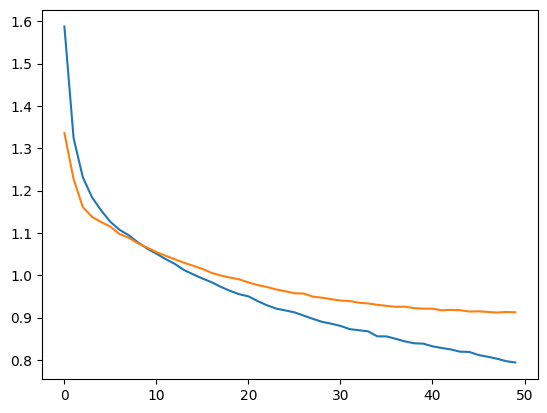

In [50]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [55]:
for batch in valid_dataloader:
    first_item = batch
    break
print(first_item)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[tensor([444, 262, 322,  ..., 278,  17, 195]), tensor([918, 885, 763,  ..., 213,  57, 305]), tensor([1., 2., 3.,  ..., 3., 4., 4.])]


In [54]:
# take a user & get watch_time against all videos
model(torch.full((batch_size,), 3), first_item[1])

tensor([[4.1278],
        [4.4255],
        [3.2254],
        ...,
        [4.0275],
        [3.8810],
        [4.5791]], grad_fn=<AddBackward0>)